<a href="https://colab.research.google.com/github/richasethi3/Food_Image_Recognition/blob/master/Food_Image_Recognition_FastAI_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 6.5MB/s 
     |████████████████████████████████| 51kB 4.4MB/s 
     |████████████████████████████████| 194kB 10.5MB/s 
     |████████████████████████████████| 1.2MB 13.1MB/s 
     |████████████████████████████████| 61kB 5.4MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
Mounted at /content/gdrive


In [ ]:
#import libraries
import torch
from fastbook import *
from fastai.vision.widgets import *
from fastai.vision.all import *
import warnings
warnings.filterwarnings("ignore")
import fastai.callback.all

%reload_ext autoreload
%autoreload 2
%matplotlib inline

#Data Setup

In [ ]:
#set the path
path = Path('/content/gdrive/MyDrive/Kaggle')
path_images = path/'images'
path_meta = path/'meta'/'meta'

In [ ]:
#read image and label csv
classes = pd.read_csv(path_meta/'classes.txt', header=None, index_col=0,)
labels = pd.read_csv(path_meta/'labels.txt', header=None)
classes['map'] = labels[0].values
classes_to_labels = classes['map'].to_dict()

In [ ]:
labels.head()

0
0       Apple pie
1  Baby back ribs
2         Baklava
3  Beef carpaccio
4    Beef tartare

In [ ]:
print(labels[0].nunique())

101


In [ ]:
path_train = path/'mini_train'
path_test = path/'mini_test'

In [ ]:
#define a function to create mini food dataset
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    shutil.rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    shutil.copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [ ]:
#create a list with food classes of interest
food_list = ['bibimbap', 'chicken_curry', 'macarons', 'pad_thai', 'paella', 'peking_duck', 'pho', 'ramen', 'samosa', 'takoyaki']
src_train = '/content/gdrive/MyDrive/Kaggle/trainset'
dest_train = '/content/gdrive/MyDrive/Kaggle/mini_train'
src_test = '/content/gdrive/MyDrive/Kaggle/testset'
dest_test = '/content/gdrive/MyDrive/Kaggle/mini_test'

In [ ]:
#copy the images
import shutil
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into bibimbap
Copying images into chicken_curry
Copying images into macarons
Copying images into pad_thai
Copying images into paella
Copying images into peking_duck
Copying images into pho
Copying images into ramen
Copying images into samosa
Copying images into takoyaki


In [ ]:
import shutil
print("Creating train data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating train data folder with new classes
Copying images into bibimbap
Copying images into chicken_curry
Copying images into macarons
Copying images into pad_thai
Copying images into paella
Copying images into peking_duck
Copying images into pho
Copying images into ramen
Copying images into samosa
Copying images into takoyaki


In [ ]:
print("Total number of samples in mini train folder")

!find mini_train -type d -or -type f -printf '.' | wc -c

Total number of samples in mini train folder
7500


In [ ]:
print("Total number of samples in mini test folder")

!find mini_test -type d -or -type f -printf '.' | wc -c

Total number of samples in mini test folder
2500


In [ ]:
#verify number of images in train set
labels = os.listdir(path_train)
print("No. of labels: {}".format(len(labels)))
print("-----------------")
print('No. of images in train set')
print('')
for label in labels:
    print("{}, {} files".format(label, len(os.listdir("/content/gdrive/MyDrive/Kaggle/mini_train/"+label))))

No. of labels: 10
-----------------
No. of images in train set

bibimbap, 750 files
chicken_curry, 750 files
macarons, 750 files
pad_thai, 750 files
paella, 750 files
peking_duck, 750 files
pho, 750 files
ramen, 750 files
samosa, 750 files
takoyaki, 750 files


In [ ]:
#verify number of images in test set
labels = os.listdir(path_train)
print("No. of labels: {}".format(len(labels)))
print("-----------------")
print('No. of images in test set')
print('')
for label in labels:
    print("{}, {} files".format(label, len(os.listdir("/content/gdrive/MyDrive/Kaggle/mini_test/"+label))))

No. of labels: 10
-----------------
No. of images in test set

bibimbap, 250 files
chicken_curry, 250 files
macarons, 250 files
pad_thai, 250 files
paella, 250 files
peking_duck, 250 files
pho, 250 files
ramen, 250 files
samosa, 250 files
takoyaki, 250 files


In [ ]:
#number of pixels in each image
def get_num_pixels(filepath):
    width, height = Image.open(filepath).size
    return width,height
print(get_num_pixels("/content/gdrive/MyDrive/Kaggle/mini_train/bibimbap/1006709.jpg"))

(512, 384)


#Modeling

In [ ]:
#create a datablock and dataloader without extra image augementation and image reszing on the batch
normblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=Pipeline([parent_label, classes_to_labels.__getitem__]),
                 item_tfms=[Resize(256)],
                 batch_tfms=[*aug_transforms(xtra_tfms=None),
                             Normalize.from_stats(*imagenet_stats)])

norm_dls = normblock.dataloaders(path_train, bs=64)

In [ ]:
norm_dls.c, norm_dls.vocab

(10,
 ['Bibimbap', 'Chicken curry', 'Macarons', 'Pad thai', 'Paella', 'Peking duck', 'Pho', 'Ramen', 'Samosa', 'Takoyaki'])

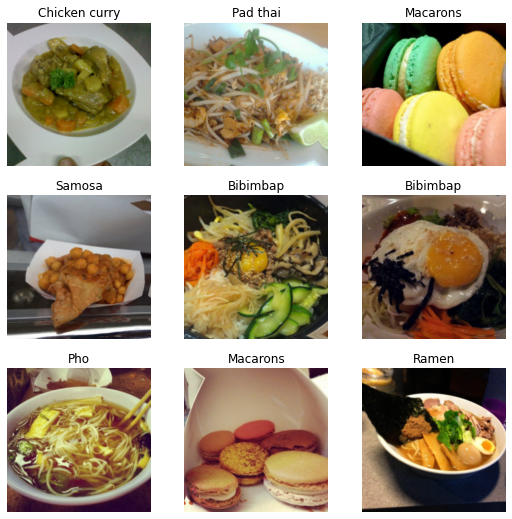

In [ ]:
#visualize teh images
norm_dls.show_batch(max_n=9, nrows=3, ncols=3)

In [ ]:
#create resent 34 learner
learn_0 = cnn_learner(norm_dls, resnet34, metrics=accuracy)

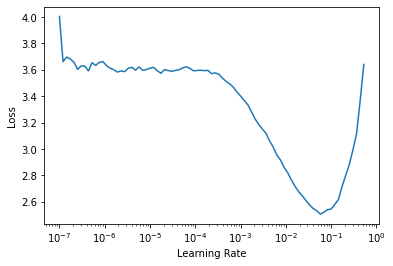

In [ ]:
#find learning rate
lr_min,lr_steep = learn_0.lr_find()

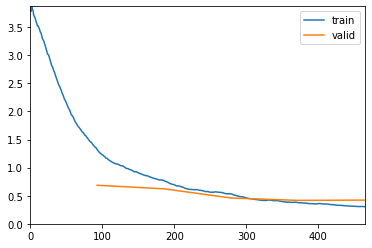

In [ ]:
#fit 1 cycle
learn_0.fit_one_cycle(5, 3e-3, cbs=[ShowGraphCallback()])

In [ ]:
%cd /content/gdrive/MyDrive/Kaggle/models_mini

/content/gdrive/MyDrive/Kaggle/models_mini


In [ ]:
#save model
learn_0.save('model34_stage_1_no_aug')

Path('models/model34_stage_1.pth')

In [ ]:
#create resnet 50 learner
learn_1 = cnn_learner(norm_dls, resnet50, metrics=accuracy)

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.0012022644514217973)

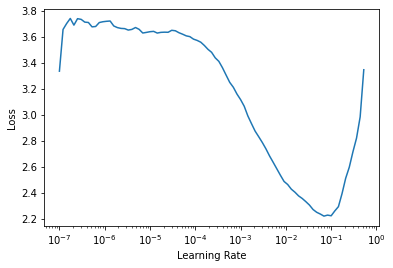

In [ ]:
learn_1.lr_find()

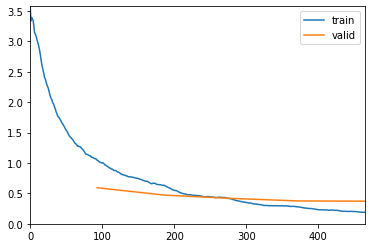

In [ ]:
learn_1.fit_one_cycle(5, 3e-3, cbs=[ShowGraphCallback()])

Based on a lower loss for train set this model seems to be overfitting.

In [ ]:
learn_1.save('model50_stage_1_no_aug')

Path('models/model50_stage_1_no_aug.pth')

In [ ]:
#create a datablock without image augmentation applied on each batch with image size 128
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=Pipeline([parent_label, classes_to_labels.__getitem__]),
                 item_tfms=[Resize(460)],
                 batch_tfms=[*aug_transforms(size=128, min_scale=0.75),
                             Normalize.from_stats(*imagenet_stats)])

dls = dblock.dataloaders(path_train, bs=64)

In [ ]:
#create resnet 34 learner
learn_2 = cnn_learner(dls, resnet34, metrics=accuracy)

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.013182567432522774)

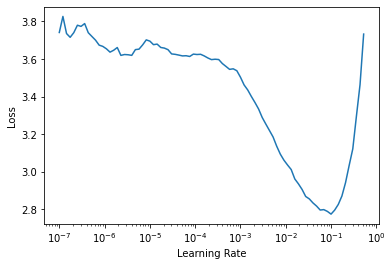

In [ ]:
learn_2.lr_find()

In [ ]:
learn_2.fit_one_cycle(5, 3e-3)

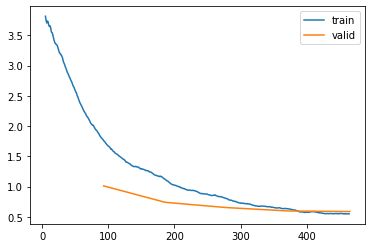

In [ ]:
learn_2.recorder.plot_loss()

The model is converging but we need to work on the accuracy.

In [ ]:
learn_2.save('model34_stage_1_size(128)')

Path('models/model34_stage_1_size(128).pth')

In [ ]:
#create a datablock without image augmentation applied on each batch with image size 224
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=Pipeline([parent_label, classes_to_labels.__getitem__]),
                 item_tfms=[Resize(460)],
                 batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                             Normalize.from_stats(*imagenet_stats)])

dls = dblock.dataloaders(path_train, bs=64)

In [ ]:
#create resnet 34 learner
learn_3 = cnn_learner(dls, resnet34, metrics=accuracy)

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.013182567432522774)

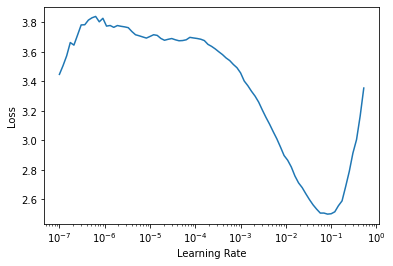

In [ ]:
learn_3.lr_find()

In [ ]:
learn_3.fit_one_cycle(5, 3e-3)

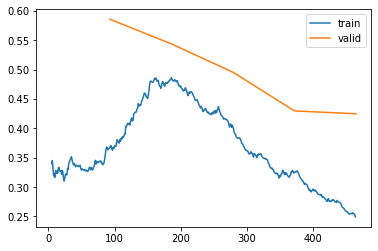

In [ ]:
learn_3.recorder.plot_loss()

Better accuracy but the losses aren't converging

In [ ]:
learn_3.save('model34_stage_1_size(224)')

Path('models/model34_stage_1_size(224).pth')

In [ ]:
#create a datatblock with data augementation and image size 224
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(seed=42),
                   get_y=Pipeline([parent_label, classes_to_labels.__getitem__]),
                   item_tfms=[Resize(460)],
                   batch_tfms=[*aug_transforms(do_flip=True, flip_vert=True, max_rotate=15,
                                               max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                                               p_affine=1, p_lighting=1, size=224, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
dls = dblock.dataloaders(path_train, bs=64)

In [ ]:
dls.c, dls.vocab

(10,
 ['Bibimbap', 'Chicken curry', 'Macarons', 'Pad thai', 'Paella', 'Peking duck', 'Pho', 'Ramen', 'Samosa', 'Takoyaki'])

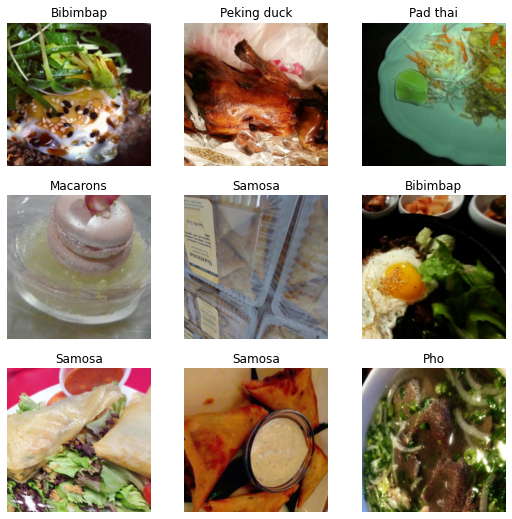

In [ ]:
dls.train.show_batch()

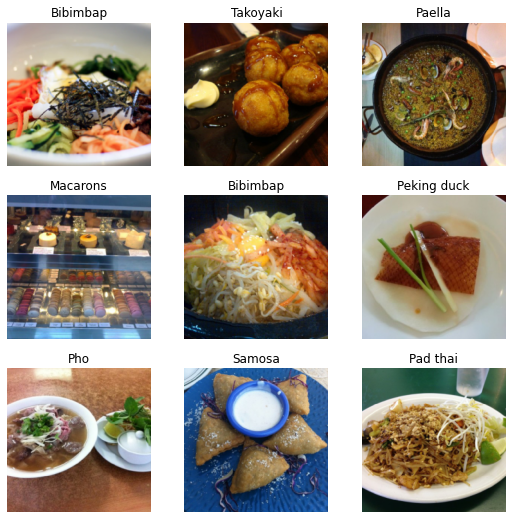

In [ ]:
dls.valid.show_batch()

In [ ]:
#create learner with resnet 34
learn_4 = cnn_learner(dls, resnet34, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.004365158267319202)

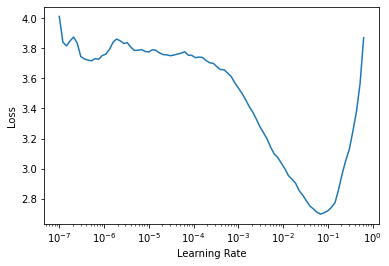

In [ ]:
learn_4.lr_find()

In [ ]:
learn_4.fit_one_cycle(8, 3e-3)

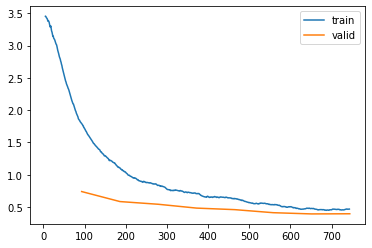

In [ ]:
learn_4.recorder.plot_loss()

In [ ]:
learn_4.save('model34_stage_1_aug')

Path('models/model34_stage_1_aug.pth')

In [ ]:
learn_4.unfreeze()

SuggestedLRs(lr_min=1.0964782268274575e-05, lr_steep=1.9054607491852948e-06)

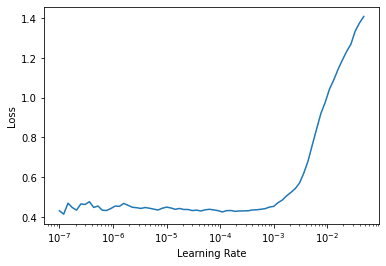

In [ ]:
learn_4.lr_find()

In [ ]:
learn_4.fit_one_cycle(12, lr_max=slice(2e-6,2e-4))

The accuracy is decent and the losses are close, let's see if we can do better.

In [ ]:
learn_4.save('model34_stage_2_aug')

Path('models/model34_stage_2_aug.pth')

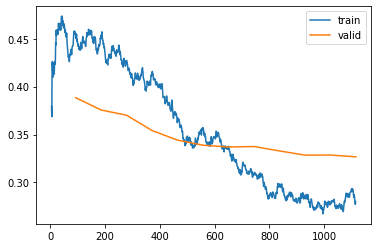

In [ ]:
learn_4.recorder.plot_loss()

In [ ]:
learn_4.unfreeze()

SuggestedLRs(lr_min=4.365158383734525e-06, lr_steep=4.786300905834651e-06)

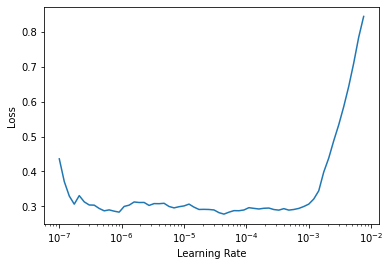

In [ ]:
learn_4.lr_find()

In [ ]:
learn_4.fit_one_cycle(6, lr_max=slice(1e-6,1e-4))

The accuracy and the losses aren't improving.


In [ ]:
learn_4.save('model34_stage_3_aug')

Path('models/model34_stage_3_aug.pth')

In [ ]:
#create a learner with resnet 50
learn_5 = cnn_learner(dls, resnet50, metrics=[accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.001737800776027143)

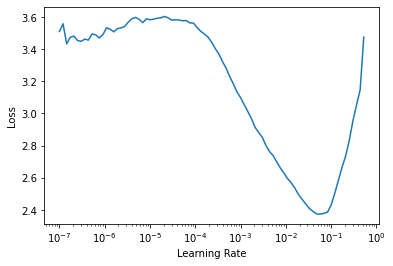

In [ ]:
learn_5.lr_find()

In [ ]:
learn_5.fit_one_cycle(8, 3e-3)

In [ ]:
learn_5.save('model50_stage_1_aug')

Path('models/model50_stage_1_aug.pth')

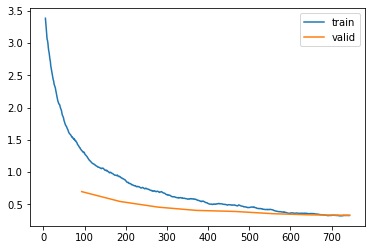

In [ ]:
learn_5.recorder.plot_loss()

90% accuracy with converging losses, this was used as the final model

In [ ]:
learn_5.unfreeze()

SuggestedLRs(lr_min=7.585775847473997e-08, lr_steep=1.4454397387453355e-05)

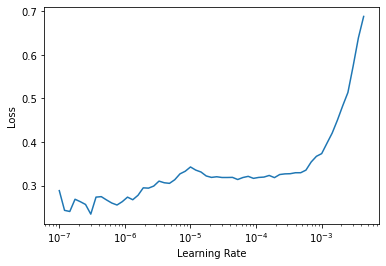

In [ ]:
learn_5.lr_find()

In [ ]:
learn_5.fit_one_cycle(4, lr_max=slice(1e-4))

In [ ]:
learn_5.save('model50_stage_2_aug')

Path('models/model50_stage_2_aug.pth')

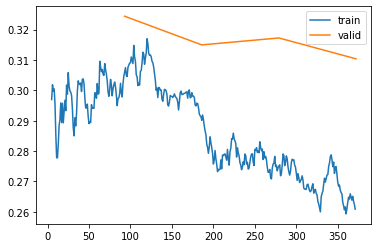

In [ ]:
learn_5.recorder.plot_loss()

In [ ]:
%cd /content/gdrive/MyDrive/Kaggle/models_mini

/content/gdrive/MyDrive/Kaggle/models_mini


In [ ]:
learn_5.load('model50_stage_1_aug')

In [ ]:
learn_5.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
learn_inf.dls.vocab

['Bibimbap', 'Chicken curry', 'Macarons', 'Pad thai', 'Paella', 'Peking duck', 'Pho', 'Ramen', 'Samosa', 'Takoyaki']

#Model Evaluation

In [ ]:
interp = ClassificationInterpretation.from_learner(learn_5)

In [ ]:
interp.most_confused(min_val=5)

[('Ramen', 'Pho', 12),
 ('Chicken curry', 'Peking duck', 7),
 ('Pho', 'Ramen', 7),
 ('Samosa', 'Takoyaki', 6),
 ('Chicken curry', 'Samosa', 5),
 ('Peking duck', 'Chicken curry', 5)]

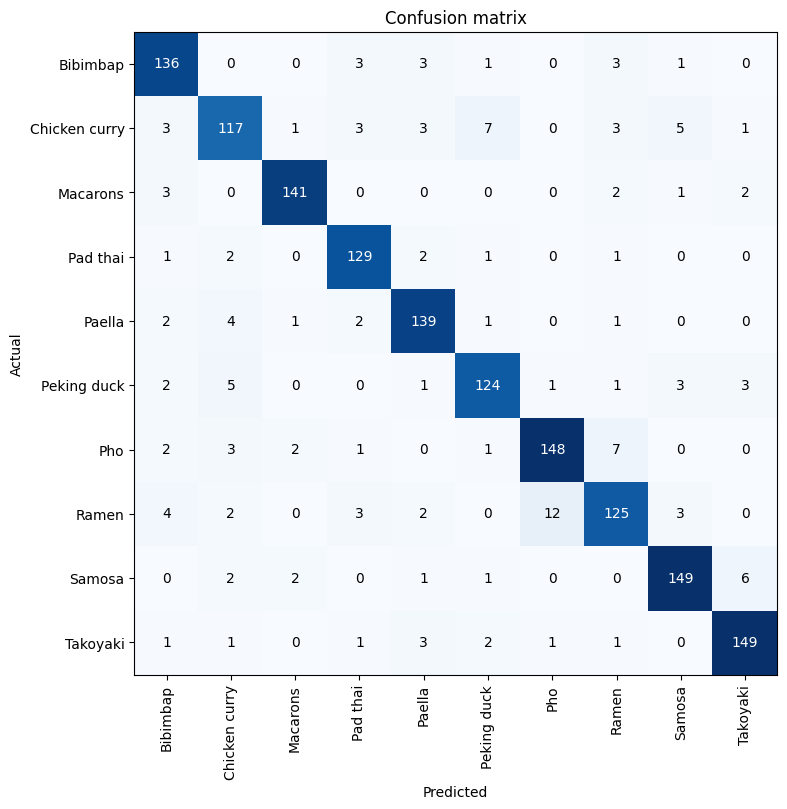

In [ ]:
interp.plot_confusion_matrix(figsize=(8, 8), dpi=100)

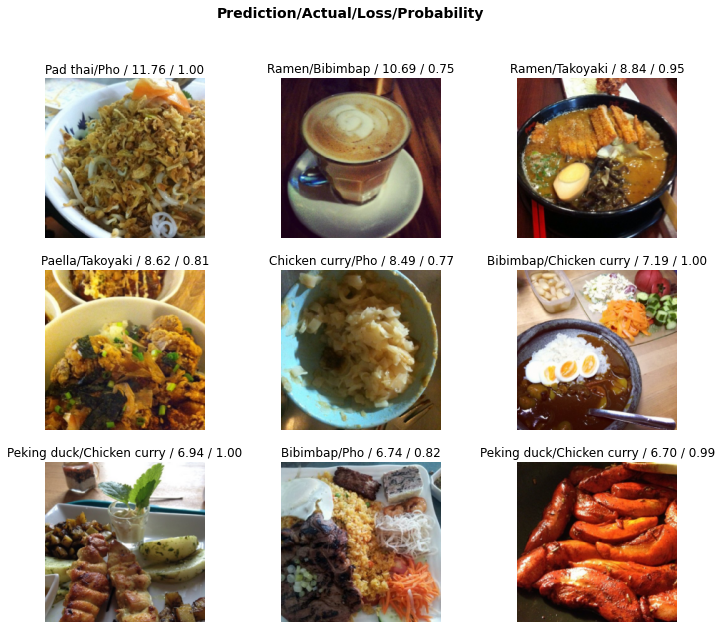

In [ ]:
interp.plot_top_losses(9, figsize=(12,10))

In [ ]:
import requests
from io import BytesIO
import pprint
import json
from PIL import Image

In [ ]:
def fetch_image(url):
  response = requests.get(url)
  image_bytes = io.BytesIO(response.content)
  img = PILImage.create(image_bytes)
  return img

In [ ]:
def predict(url):
    img = fetch_image(url)
    pred_class,pred_idx,outputs = learn_5.predict(img)
    res =  zip(dls.vocab, outputs.tolist())
    predictions = sorted(res, key=lambda x:x[1], reverse=True)
    top_predictions = predictions[0:3]
    pprint.pprint(top_predictions)
    return img.to_thumb(500, 500)

In [ ]:
food = 'https://prods3.imgix.net/images/articles/2016_09/Feature-Pad-Thai.jpg?auto=format%2Ccompress&ixjsv=2.2.3'

[('Pad thai', 0.9999922513961792),
 ('Ramen', 3.621670884967898e-06),
 ('Bibimbap', 1.7819019149101223e-06)]


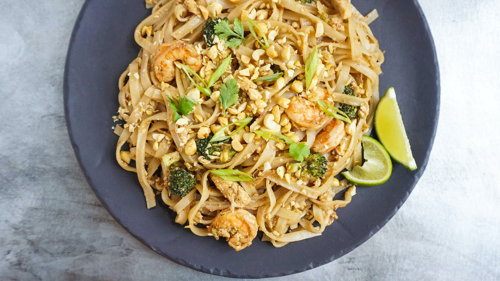

In [ ]:
predict(food)

In [ ]:
img = PILImage.create('/content/gdrive/MyDrive/Kaggle/mini_test/samosa/3582002.jpg')
x, = first(dls.test_dl([img]))

In [ ]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])

#Visualizing activation layers

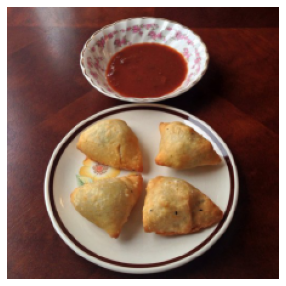

In [ ]:
show_image(x_dec)

In [ ]:
layers = flatten_model(learn_5.model)

In [ ]:
custom_hook = hook_outputs(layers)

In [ ]:
custom_hook.stored

(#134) [None,None,None,None,None,None,None,None,None,None...]

In [ ]:
learn_5.predict(x_dec)

('Samosa',
 tensor(8),
 tensor([7.7276e-07, 6.3269e-04, 9.8906e-05, 2.1409e-06, 1.6018e-06, 1.9674e-05, 7.0393e-06, 1.5061e-07, 9.9862e-01, 6.1542e-04]))

In [ ]:
custom_hook.stored

(#134) [TensorImage([[[[ 1.4910e+00,  1.4678e+00,  1.3313e+00,  ...,  3.8773e+00,  3.8399e+00,  1.8100e+00],
          [ 2.6014e-01,  3.7878e-01,  3.9151e-01,  ...,  4.2304e-01,  4.5366e-01,  6.3304e-01],
          [ 1.5201e-01,  1.2823e-01,  1.7218e-01,  ...,  3.3650e-01,  3.3449e-01,  3.8465e-01],
          ...,
          [ 8.3345e-02,  1.4415e-01,  3.6475e-01,  ...,  3.5509e-01,  2.4451e-01,  2.7852e-01],
          [ 5.8299e-02, -3.3363e-02, -9.2057e-02,  ...,  3.1474e-01,  3.1172e-01,  4.1577e-01],
          [ 9.1837e-01,  1.8231e+00,  1.9291e+00,  ...,  3.8160e+00,  3.8262e+00,  4.2591e+00]],

         [[-3.1360e+00, -3.1372e+00, -2.6110e+00,  ..., -1.6970e+00, -1.6892e+00, -1.1313e+00],
          [-3.6360e+00, -3.5492e+00, -2.9055e+00,  ..., -2.0501e+00, -2.0406e+00, -1.3569e+00],
          [-3.2459e+00, -3.2677e+00, -2.8610e+00,  ..., -2.0899e+00, -2.0869e+00, -1.4040e+00],
          ...,
          [-1.8758e+00, -2.2711e+00, -2.3875e+00,  ..., -1.9185e+00, -1.9316e+00, -1.3892e+

In [ ]:
[custom_hook.stored[i].shape for i in range(len(custom_hook.stored))]

[(1, 64, 112, 112),
 (1, 64, 112, 112),
 (1, 64, 112, 112),
 (1, 64, 56, 56),
 (1, 64, 56, 56),
 (1, 64, 56, 56),
 (1, 64, 56, 56),
 (1, 64, 56, 56),
 (1, 256, 56, 56),
 (1, 256, 56, 56),
 (1, 256, 56, 56),
 (1, 256, 56, 56),
 (1, 256, 56, 56),
 (1, 64, 56, 56),
 (1, 64, 56, 56),
 (1, 64, 56, 56),
 (1, 64, 56, 56),
 (1, 256, 56, 56),
 (1, 256, 56, 56),
 (1, 256, 56, 56),
 (1, 64, 56, 56),
 (1, 64, 56, 56),
 (1, 64, 56, 56),
 (1, 64, 56, 56),
 (1, 256, 56, 56),
 (1, 256, 56, 56),
 (1, 256, 56, 56),
 (1, 128, 56, 56),
 (1, 128, 56, 56),
 (1, 128, 28, 28),
 (1, 128, 28, 28),
 (1, 512, 28, 28),
 (1, 512, 28, 28),
 (1, 512, 28, 28),
 (1, 512, 28, 28),
 (1, 512, 28, 28),
 (1, 128, 28, 28),
 (1, 128, 28, 28),
 (1, 128, 28, 28),
 (1, 128, 28, 28),
 (1, 512, 28, 28),
 (1, 512, 28, 28),
 (1, 512, 28, 28),
 (1, 128, 28, 28),
 (1, 128, 28, 28),
 (1, 128, 28, 28),
 (1, 128, 28, 28),
 (1, 512, 28, 28),
 (1, 512, 28, 28),
 (1, 512, 28, 28),
 (1, 128, 28, 28),
 (1, 128, 28, 28),
 (1, 128, 28, 28),
 (1

In [ ]:
stored_hooks_rank = [len(custom_hook.stored[i].shape) for i in range(len(custom_hook.stored))]

In [ ]:
min_rank = min([len(custom_hook.stored[i].shape) for i in range(len(custom_hook.stored))]); min_rank

2

In [ ]:
first_flat_layer = stored_hooks_rank.index(min_rank); first_flat_layer

126

In [ ]:
def show_2D_act(hook, l=0, nrows=3, ncols=8, s=20, cmap='inferno'):
    fig, axes = plt.subplots(nrows, ncols, figsize=(s,s/3))
    fig.subplots_adjust(hspace=0.2, wspace=0, left=0, right=1, top=1, bottom=0)
    for i, ax in enumerate(axes.flat):
        ax.imshow(hook.stored[l][0][i], cmap=cmap)
        ax.set_axis_off()

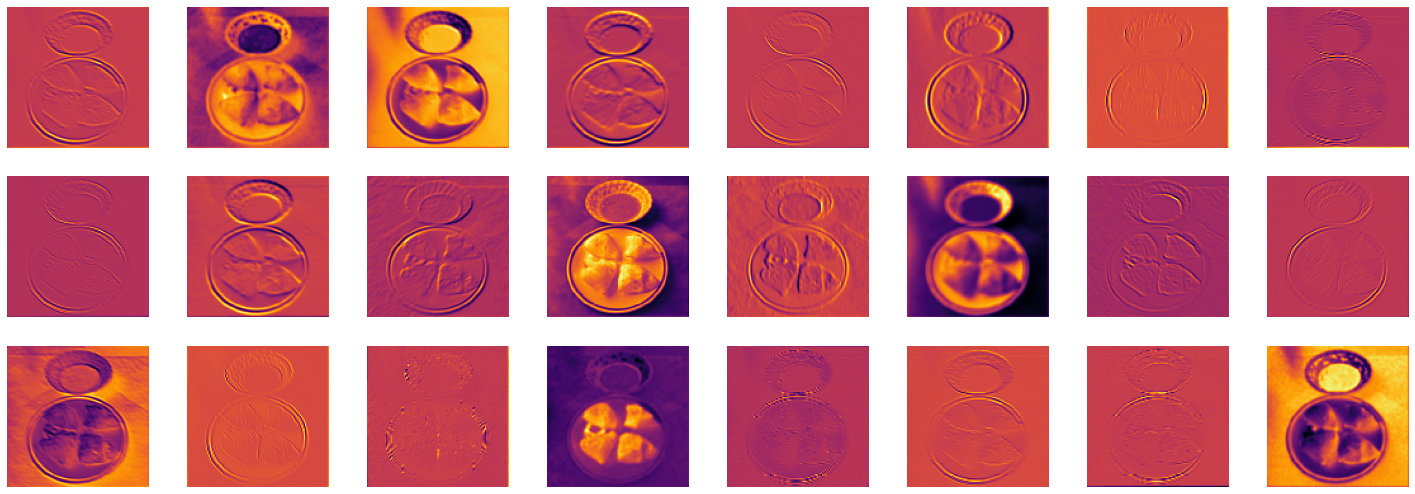

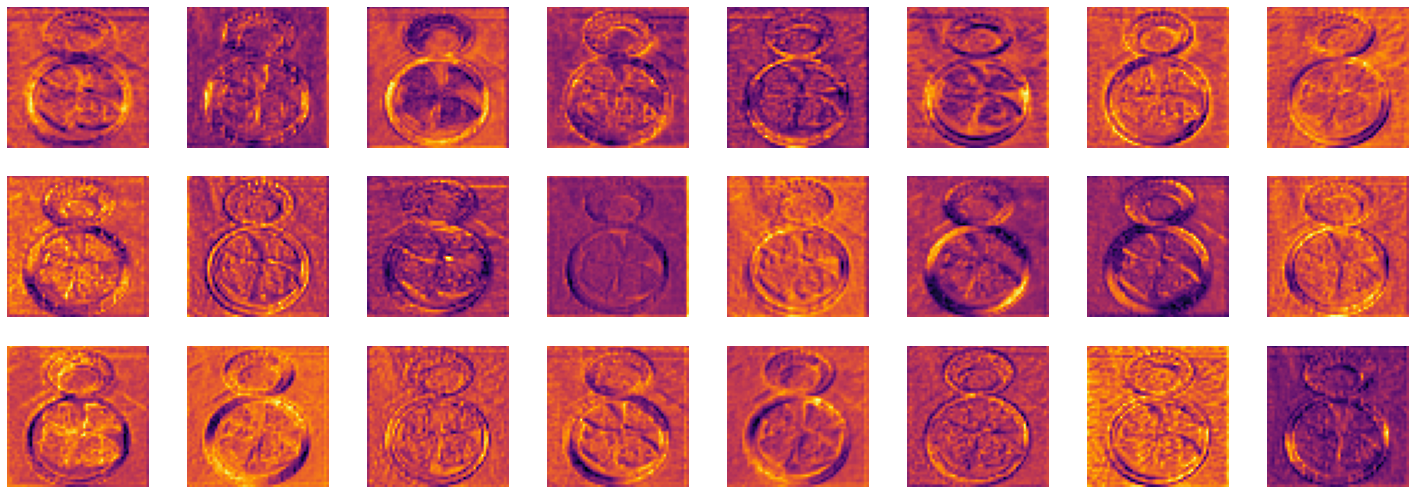

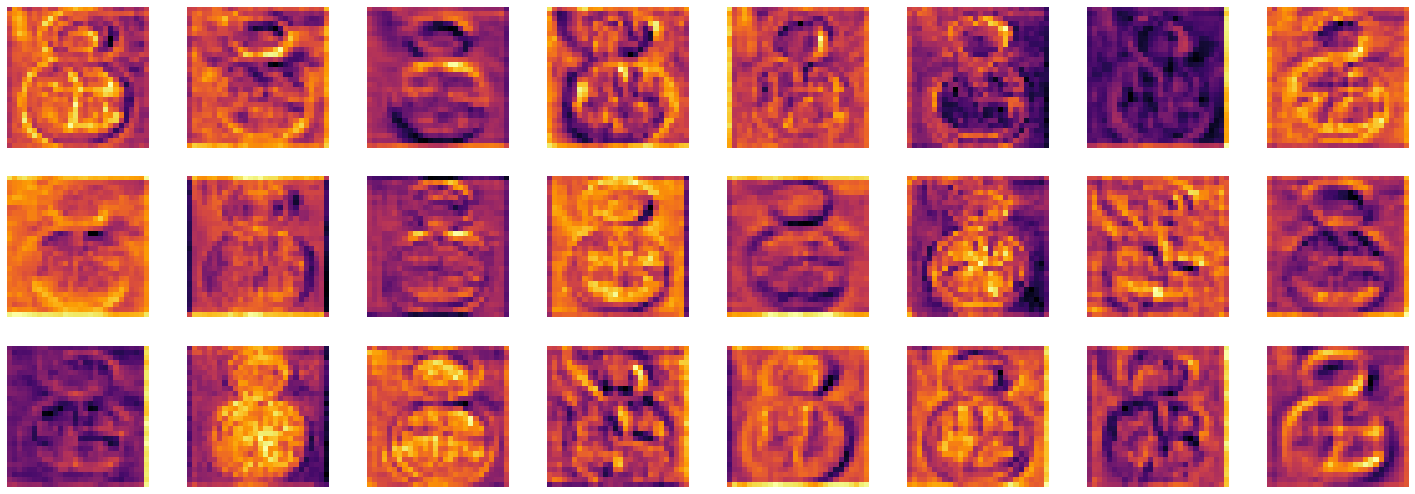

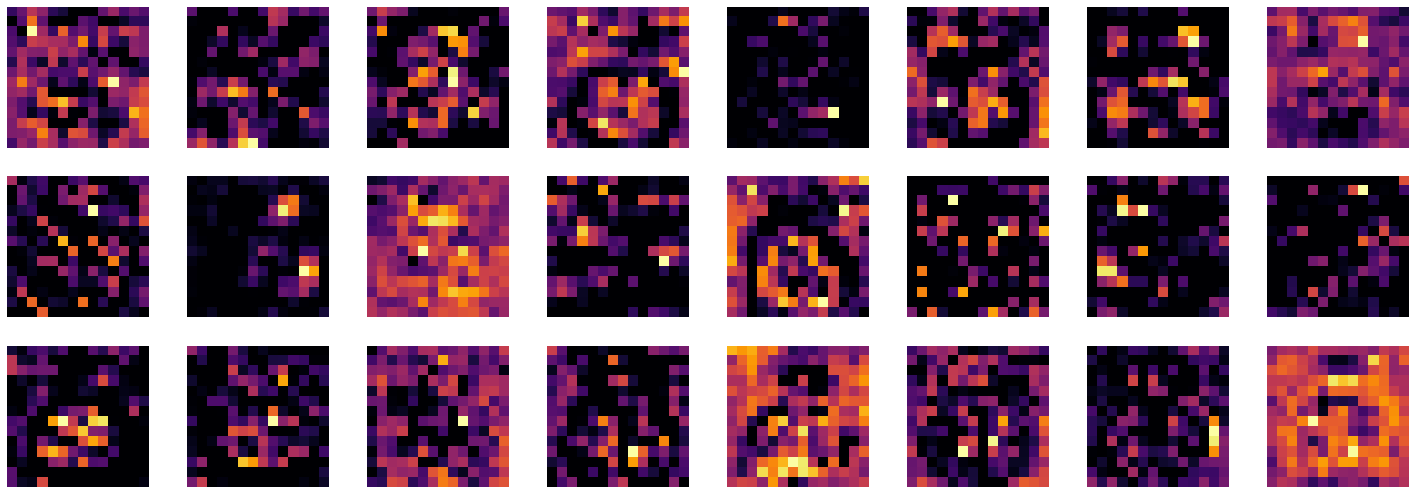

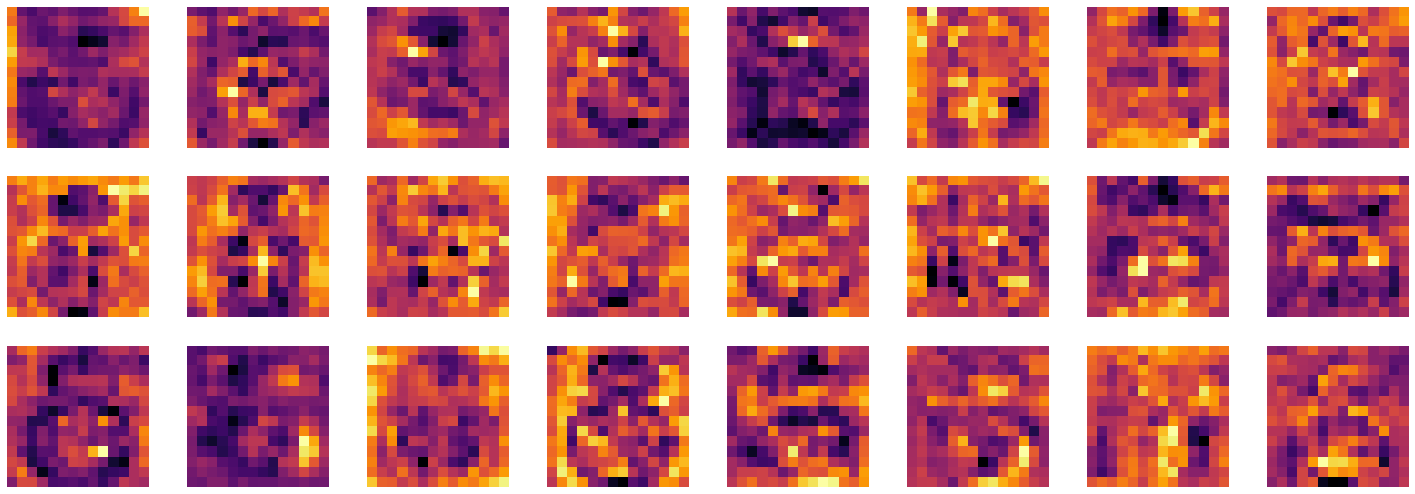

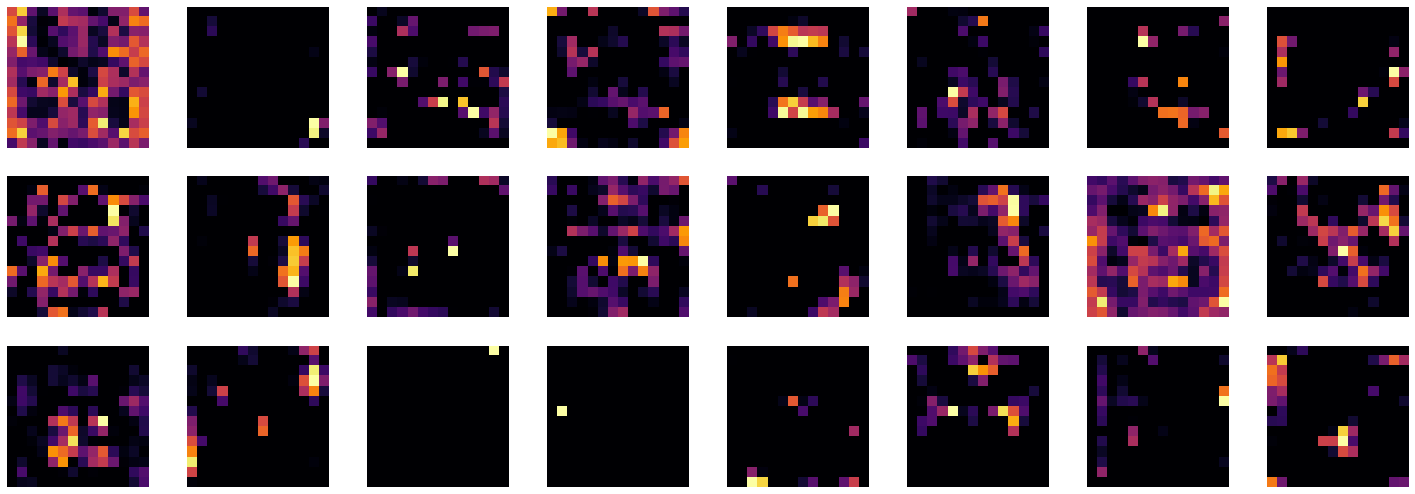

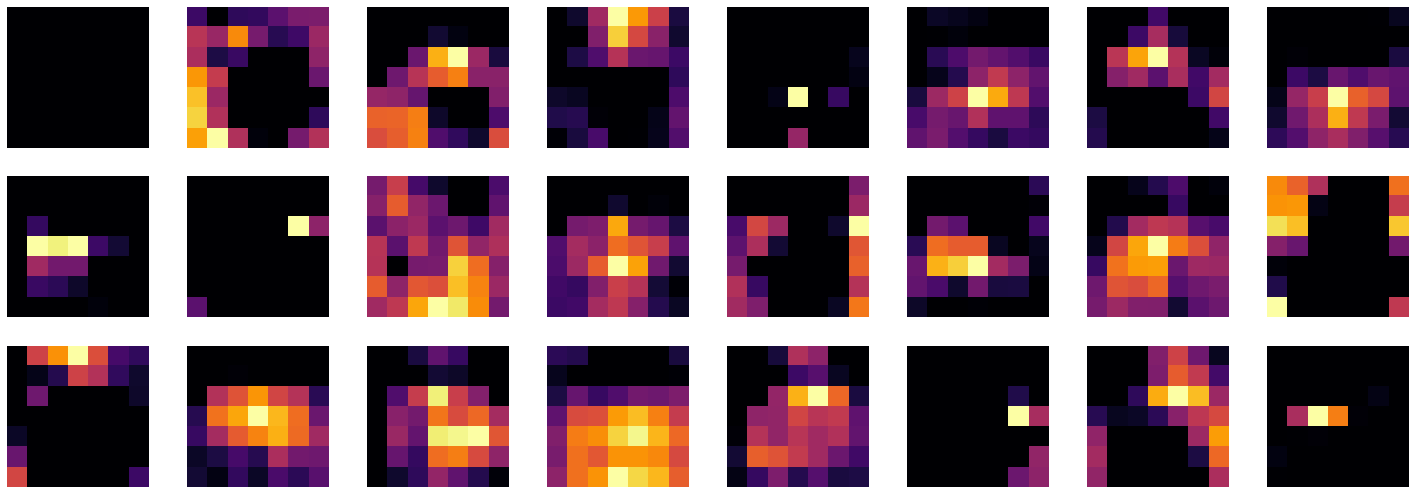

In [ ]:
for i in range(0,first_flat_layer,20):
    show_2D_act(custom_hook, i)

In [ ]:
{k: dls.vocab.o2i[k] for k in list(dls.vocab.o2i)}

{'Bibimbap': 0,
 'Chicken curry': 1,
 'Macarons': 2,
 'Pad thai': 3,
 'Paella': 4,
 'Peking duck': 5,
 'Pho': 6,
 'Ramen': 7,
 'Samosa': 8,
 'Takoyaki': 9}

In [ ]:
img = PILImage.create('/content/gdrive/MyDrive/Kaggle/mini_test/samosa/3582002.jpg')
x, = first(dls.test_dl([img]))

In [ ]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])

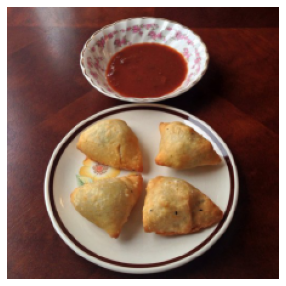

In [ ]:
show_image(x_dec)

In [ ]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
def heatmap(x, cls):
  with HookBwd(learn_5.model[0]) as hookg:
    with Hook(learn_5.model[0]) as hook:
        output = learn_5.model.eval()(x)
        act = hook.stored
    output[0,cls].backward()
    grad = hookg.stored
  w = grad[0].mean(dim=[1,2], keepdim=True)
  cam_map = (w * act[0]).sum(0)
  _,ax = plt.subplots()
  x_dec.show(ctx=ax)
  ax.imshow(cam_map.detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma')  

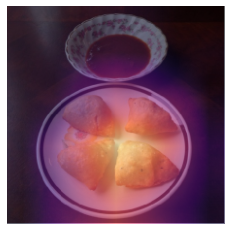

In [ ]:
heatmap(x, 8)

#Inferencing

In [ ]:
testblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 get_y=Pipeline([parent_label, classes_to_labels.__getitem__]),
                 item_tfms=[Resize(256)],
                 batch_tfms=(Normalize.from_stats(*imagenet_stats)))

test_dls = block.dataloaders(path_test, bs=16)

In [ ]:
learn_5.load('model50_stage_1_aug')

In [ ]:
learn_5.dls = test_dls

In [ ]:
learn_5.validate()

(#2) [0.22945572435855865,0.9399999976158142]

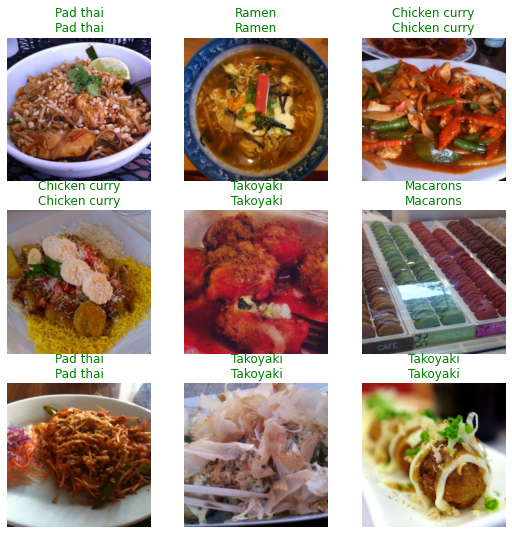

In [ ]:
learn_5.show_results()

#GUI creation

In [ ]:
btn_upload = widgets.FileUpload()

# Button to classify
btn_run = widgets.Button(description='Classify')

# Display a thumb of the image
out_pl = widgets.Output()
out_pl.clear_output()

# Calculation and display of the category prediction
lbl_pred = widgets.Label()
def on_click_classify(change):
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(500, 500))
  pred_class,pred_idx,outputs = learn_5.predict(img)
  res =  zip(dls.vocab, outputs.tolist())
  predictions = sorted(res, key=lambda x:x[1], reverse=True)
  top_predictions = predictions[0:3]
  pprint.pprint(top_predictions)
btn_run.on_click(on_click_classify)

In [ ]:
VBox([widgets.Label('Select your food!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

[('Paella', 0.9980525970458984),
 ('Bibimbap', 0.0014485573628917336),
 ('Chicken curry', 0.0002047351299552247)]


In [ ]:
food = widgets.Label("Enter image url!")

url = widgets.Text()

# Button to classify
btn_run = widgets.Button(description='Classify')

# Display a thumb of the image
out_pl = widgets.Output()
out_pl.clear_output()

# Calculation and display of the category prediction
lbl_pred = widgets.Label()
def on_click_classify(change):
  response = requests.get(url.value)
  image_bytes = io.BytesIO(response.content)
  img = PILImage.create(image_bytes)
  out_pl.clear_output()
  with out_pl: display(img.to_thumb(500, 500))
  pred_class,pred_idx,outputs = learn_5.predict(img)
  res =  zip(dls.vocab, outputs.tolist())
  predictions = sorted(res, key=lambda x:x[1], reverse=True)
  top_predictions = predictions[0:3]
  pprint.pprint(top_predictions)
btn_run.on_click(on_click_classify)

In [ ]:
VBox([food, url, btn_run, out_pl, lbl_pred])

[('Pad thai', 0.9946607947349548),
 ('Ramen', 0.0019439655588939786),
 ('Paella', 0.0016117237973958254)]
